In [1]:
import tensorflow as tf
import numpy as np
import sparse

from base_data import BaseDataSet
from data import DataCorpus

%matplotlib inline
import seaborn
import matplotlib.pyplot as plt

/Users/muzikin/anaconda/envs/tensorforce/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/muzikin/anaconda/envs/tensorforce/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [20]:
%%time

train = BaseDataSet('train.csv')
train.process(truncate=None, max_days=None, rebase=False)

[2018-05-27 22:27:10.775650] INFO: BaseData/train.csv: Loading data...
[2018-05-27 22:27:12.038731] INFO: BaseData/train.csv: Loaded data shape: (490513, 10)
[2018-05-27 22:27:32.902096] INFO: BaseData/train.csv: Converting to RUB...
[2018-05-27 22:28:53.036768] INFO: BaseData/train.csv: Calculating relative days...
[2018-05-27 22:30:51.416167] INFO: BaseData/train.csv: Aggregating by daily sums...
[2018-05-28 00:20:11.527214] INFO: BaseData/train.csv: Saving aggregated csv file...
[2018-05-28 00:20:16.705717] INFO: BaseData/train.csv: Making sparse data array...
[2018-05-28 00:20:16.707943] INFO: BaseData/train.csv: max_days inferred from data: 481
[2018-05-28 00:20:21.575382] INFO: BaseData/train.csv: Saving sparse array...
[2018-05-28 00:20:23.218801] INFO: BaseData/train.csv: Done.
CPU times: user 1h 19min 2s, sys: 33min 58s, total: 1h 53min
Wall time: 1h 53min 15s


In [21]:
%%time

test = BaseDataSet('test.csv')
test.process(truncate=None, max_days=None, rebase=False)

[2018-05-28 00:20:24.465271] INFO: BaseData/test.csv: Loading data...
[2018-05-28 00:20:25.380519] INFO: BaseData/test.csv: Loaded data shape: (518376, 8)
[2018-05-28 00:20:41.565874] INFO: BaseData/test.csv: Converting to RUB...
[2018-05-28 00:22:00.986351] INFO: BaseData/test.csv: Calculating relative days...
[2018-05-28 00:23:57.809587] INFO: BaseData/test.csv: Aggregating by daily sums...
[2018-05-28 01:06:16.002938] INFO: BaseData/test.csv: Saving aggregated csv file...
[2018-05-28 01:06:21.048345] INFO: BaseData/test.csv: Making sparse data array...
[2018-05-28 01:06:21.050820] INFO: BaseData/test.csv: max_days inferred from data: 487
[2018-05-28 01:06:24.253341] INFO: BaseData/test.csv: Saving sparse array...
[2018-05-28 01:06:26.296797] INFO: BaseData/test.csv: Done.
CPU times: user 34min 44s, sys: 11min 15s, total: 45min 59s
Wall time: 46min 2s


In [22]:
assert (test.aggregated_data.columns == train.aggregated_data.columns).all()

In [ ]:
for i in range(train.sparse_array_data.shape[0]):
    plt.figure(i, figsize=[16,6])
    _ = plt.imshow(np.log(train.sparse_array_data[i,:,:].todense().T + 1), cmap='Purples')

    plt.show()

In [11]:
data = DataCorpus(
    'data/sparse_array_train.npz',
    'data/sparse_array_test.npz',
    batch_size=8,
    cv_fraction=0.2,
    train_repeats=2,
    full_shuffle=False,
    log_transform=True
    
)

[2018-05-27 06:43:59.370594] INFO: DataCorpus: train data shape: (105, 512, 24)
[2018-05-27 06:43:59.396577] INFO: DataCorpus: test data shape: (114, 512, 25)
[2018-05-27 06:43:59.427977] INFO: DataCorpus: cv_fraction: 0.2, train_size: 84, cv size: 21


In [12]:
train_ids = []
cv_ids = []
with tf.Session() as sess:
    
    for ep in range(4):
        print('Fit epoch: ', ep)
        data.reset()

        #Iterate through sets:
        print('Train pass:')
        for i in range(16):
            try:
                out = sess.run(data.next_train_batch_op)
                print('train_', i)
                print(out[0]['cl_id'])
                train_ids.append(out[0]['cl_id'])
                
                # CV pass:
                print('CV pass:') 
                data.reset_cv()
                for j in range(1000):
                    try:
                        out = sess.run(data.next_cv_batch_op)
                        print(out[0]['cl_id'])
                        cv_ids.append(out[0]['cl_id'])
                    except (tf.errors.OutOfRangeError, TypeError) as e:
                        print('CV EOD')
                        break
            except tf.errors.OutOfRangeError:
                print('Train EOD')
                break
                
train_ids = np.concatenate(train_ids)
cv_ids = np.concatenate(cv_ids)


Fit epoch:  0
Train pass:
train_ 0
[ 46  76  35  42  59  94 103  91]
CV pass:
[166 186 169 187 157 163 178 154]
[183 177 180 184 162 168 196 200]
[181 160 190 198 153]
CV EOD
train_ 1
[ 22  78 137  28   5 152  85  52]
CV pass:
[162 163 186 200 154 177 198 178]
[168 160 190 166 157 196 187 180]
[169 181 183 184 153]
CV EOD
train_ 2
[ 14  31  61  11  23 122  84 142]
CV pass:
[187 190 166 180 154 162 181 160]
[168 184 198 200 169 178 163 157]
[183 196 153 177 186]
CV EOD
train_ 3
[139 143 113  54  89  58  39 134]
CV pass:
[153 162 169 166 186 183 198 187]
[157 200 168 178 154 181 160 180]
[163 196 190 177 184]
CV EOD
train_ 4
[ 10 117 100  81 138  56  32  38]
CV pass:
[162 169 160 166 190 157 196 154]
[184 200 186 177 181 187 178 180]
[183 198 153 163 168]
CV EOD
train_ 5
[ 21  88 109  41  98  69 124 136]
CV pass:
[162 168 153 178 190 157 160 177]
[154 180 186 196 183 166 184 163]
[200 181 198 169 187]
CV EOD
train_ 6
[132   1  50  29 126  25  90  48]
CV pass:
[200 157 178 184 196 198 169

[187 154 163 196 157 200 168 198]
[178 186 180 190 181 184 169 162]
[153 177 160 183 166]
CV EOD
train_ 8
[ 14 124  82  77  94  24  29  48]
CV pass:
[200 187 178 162 166 196 190 184]
[181 153 186 183 163 177 180 169]
[198 154 160 157 168]
CV EOD
train_ 9
[ 89 136 129  28  79 143  42  41]
CV pass:
[183 186 168 190 162 160 166 177]
[187 184 154 178 157 169 163 180]
[200 198 181 153 196]
CV EOD
train_ 10
[ 84  55  88 144  46  74   9 113]
CV pass:
[177 187 200 162 169 178 180 154]
[157 196 183 190 160 153 166 184]
[163 198 181 186 168]
CV EOD
train_ 11
[139  55  82  84  28  91  14 117]
CV pass:
[163 154 196 169 198 177 168 178]
[153 160 187 181 184 186 157 166]
[183 190 180 200 162]
CV EOD
train_ 12
[ 22  73  88  10  11  76 152 129]
CV pass:
[198 184 153 190 154 157 200 178]
[163 160 168 162 196 187 181 183]
[177 186 180 169 166]
CV EOD
train_ 13
[ 29 144  89 136  79  69 100   1]
CV pass:
[196 153 168 169 186 181 154 184]
[180 190 163 166 162 177 157 178]
[160 183 187 200 198]
CV EOD
train

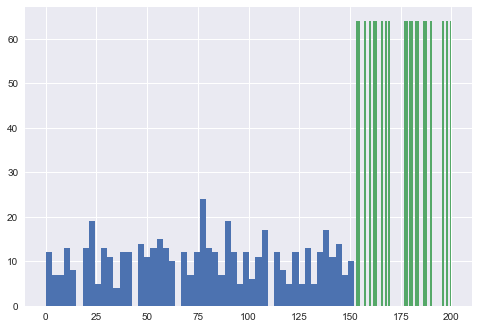

In [13]:
plt.figure(0)
_ = plt.hist(train_ids, bins=50)
_ = plt.hist(cv_ids, bins=50)

In [ ]:
with tf.Session() as sess:
    
    for ep in range(4):
        print('Fit epoch: ', ep)
        data.reset()

        #Iterate through sets:
        print('Train:')
        for i in range(16):
            try:
                out = sess.run(data.next_train_batch_op)
                print(i)
                print(out[0]['cl_id'], '-->', out[-1]['target_sum'])
            except tf.errors.OutOfRangeError:
                print('Train EOD')
                break

        print('CV:') 
        for i in range(10):
            try:
                out = sess.run(data.next_cv_batch_op)
                print(i)
                print(out[0]['cl_id'], '-->', out[-1]['target_sum'])
            except (tf.errors.OutOfRangeError, TypeError) as e:
                print('CV EOD')
                break

        print('Test: ') 
        for i in range(10):
            try:
                out = sess.run(data.next_test_batch_op)
                print(out[0]['cl_id'])
            except tf.errors.OutOfRangeError:
                print('Test EOD')
                break


In [ ]:
def to_log(data, labels):
        
    transform_op={
        'cl_id': tf.identity,
        'features': tf.log1p,
        'target_sum': tf.log1p,
        'target_flag': tf.identity,
        
    }

    transformed_data = {
       key: transform_op[key](tensor) for key, tensor in data.items()
    }

    transformed_labels = {
       key: transform_op[key](tensor) for key, tensor in labels.items()
    }
   
    return transformed_data, transformed_labels


# Data loading

train_data_array = sparse.load_npz('data/sparse_array_train.npz').todense()
# K-fold-like (not exactly): premute, than redefine train/test:
train_data_array = np.random.permutation(train_data_array) # for true K-fold

test_data_array = sparse.load_npz('data/sparse_array_test.npz').todense()

# TODO: make exact K-fold

train_data = {
    'cl_id': train_data_array[:, 0, 0].astype('int'),
    'features': train_data_array[..., 1:-2]
}
labels = {
    'cl_id': train_data_array[:, 0, 0].astype('int'),
    'target_sum': train_data_array[:, 0, -1],
    'target_flag': train_data_array[:, 0, -2].astype('bool')
}
test_data = {
    'cl_id': test_data_array[:, 0, 0].astype('int'),
    'features': test_data_array[..., 1:-2]
}
# TODO: shuffle train_data_array - redefine train/test folds -- do not redefine graph, but reinitialize datasets
# Graph def:
tf.reset_default_graph()

train_data_pl_dict = {
    key: tf.placeholder(value.dtype, value.shape, key) for key, value in train_data.items()
}
labels_pl_dict = {
     key: tf.placeholder(value.dtype, value.shape, key) for key, value in labels.items()
}

test_data_pl_dict = {
    key: tf.placeholder(value.dtype, value.shape, key) for key, value in test_data.items()
}

batch_size = 8

full_train_dataset = tf.data.Dataset.from_tensor_slices((train_data_pl_dict, labels_pl_dict))

cv_fraction = 0.7

split_size = int(train_data['cl_id'].shape[0] * cv_fraction) 

print('cv_fraction: {}, split_point at {} of {}'.format(cv_fraction, split_size, train_data['cl_id'].shape[0]))

train_dataset = full_train_dataset.take(split_size)
# Loop over train set :
train_dataset = train_dataset.map(to_log)
train_dataset = train_dataset.shuffle(buffer_size=split_size).repeat().batch(batch_size)
train_iterator = train_dataset.make_initializable_iterator()
next_train_batch = train_iterator.get_next()

cv_dataset = full_train_dataset.skip(split_size)
cv_dataset = cv_dataset.shuffle(buffer_size=train_data['cl_id'].shape[0] - split_size).batch(batch_size)
cv_iterator = cv_dataset.make_initializable_iterator()
next_cv_batch = cv_iterator.get_next()

test_dataset = tf.data.Dataset.from_tensor_slices((test_data_pl_dict, {}))
test_dataset = test_dataset.batch(batch_size)
test_iterator = test_dataset.make_initializable_iterator()
next_test_batch = test_iterator.get_next()



# print(train_dataset.output_types)
# print(train_dataset.output_shapes)

In [ ]:
train_data_array.shape

In [ ]:
test_data_array.shape

In [ ]:


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # Init datasets for every fold:
    feed_dict_train = {train_data_pl_dict[key]:  train_data[key] for key in train_data.keys()}
    feed_dict_labels = {labels_pl_dict[key]:  labels[key] for key in labels.keys()}
    feed_dict_test = {test_data_pl_dict[key]:  test_data[key] for key in test_data.keys()}
    sess.run(
        [train_iterator.initializer, cv_iterator.initializer, test_iterator.initializer],
        feed_dict={
            **feed_dict_train,
            **feed_dict_labels,
            **feed_dict_test
        }
    )
    #Iterate through sets:
    print('Train:')
    
    for i in range(4):
        try:
            out = sess.run(next_train_batch)
            print(i)
            print(out[0]['cl_id'], '-->', out[-1]['target_sum'])
        except tf.errors.OutOfRangeError:
            print('Train EOD')
            break
    
    print('CV:')
        
    for i in range(4):
        try:
            out = sess.run(next_cv_batch)
            print(i)
            print(out[0]['cl_id'], '-->', out[-1]['cl_id'])
        except tf.errors.OutOfRangeError:
            print('CV EOD')
            break
            
    print('Test: ')
        
    for i in range(4):
        try:
            out = sess.run(next_test_batch)
            print(out[0]['cl_id'])
        except tf.errors.OutOfRangeError:
            print('Test EOD')
            break
            